### Some imports and generating an interest rate / intensity time series

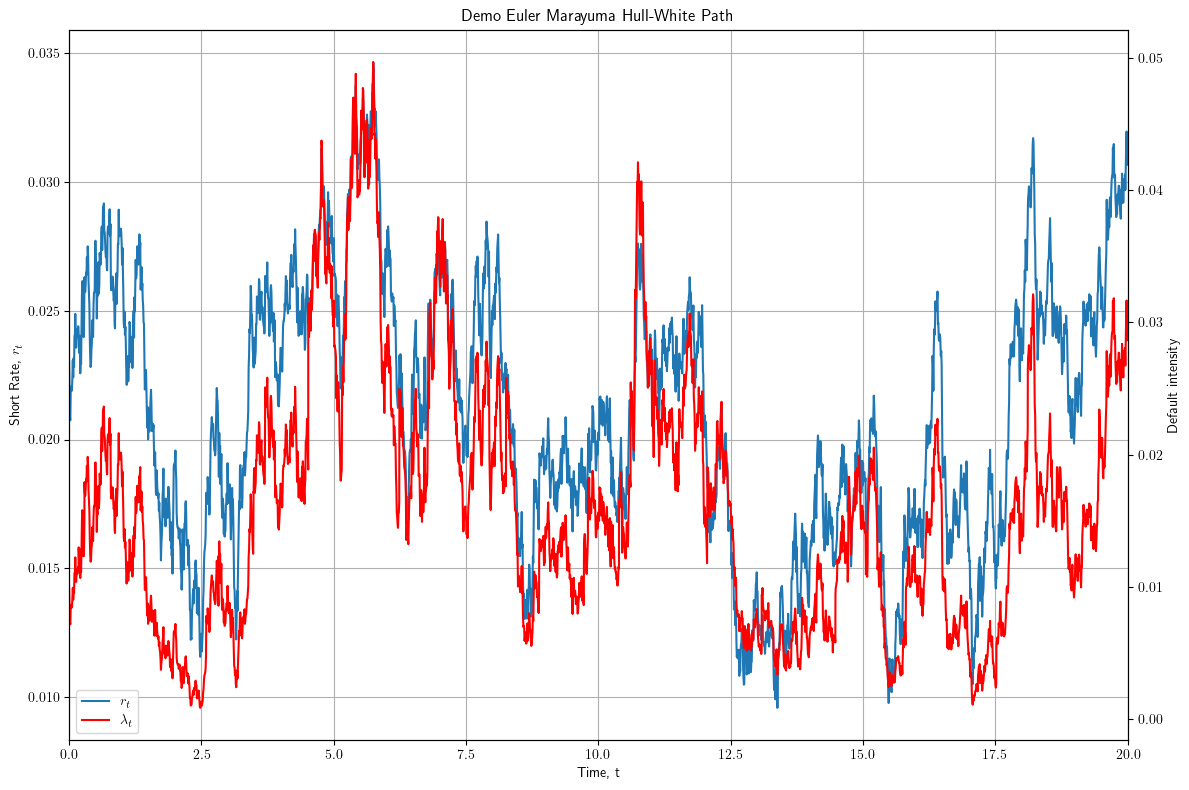

Correlation of output rho = 0.8: 0.857066704154898 


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, PCG64
from scipy.stats import norm
import scipy.optimize as optimize
import time
from joblib import Parallel, delayed

plt.rcParams['text.usetex'] = True


# Set parameters, for clarity those related to the JCIR model will be preceded by a J and those related to the Hull white by an H
t0 = 0
T = 20

# Intensity params
lambda0 = 0.01
mu = 0.01
kappa = 1
v = 0.1

j_alpha = T/4 # We should expect to see about 4 jumps,
gamma = mu/5 # With expected size mu/5

# Short rate params
r0 = 0.023
alpha = 1
theta = r0*alpha
sigma = (r0)/3

rand = Generator(PCG64())

## Generate Jumps for the JCIR
jump_times = t0 + (T-t0)*rand.random(rand.poisson(j_alpha*(T-t0),))  # The inner random generates the event count and the outer distributes them in time geometrically
jump_times.sort()
jump_intensitys = [rand.exponential(gamma) for a in jump_times] # Draws exponential intensities for each of the jumps

jumps = list(zip(jump_times,jump_intensitys)) # A list of tuples of ordered times and intensities


## Run rho 0.8 diffusion model for let's say 1280 time steps over our 10 time units, i.e. dt = 1/128
N = T*128
t_s = np.linspace(t0,T,N)
t_s = np.concatenate((t_s,jump_times))
t_s.sort()
Y_s = np.linspace(np.sqrt(lambda0), np.sqrt(lambda0), len(t_s)) 
lambdas = np.linspace(lambda0, lambda0,len(t_s))
r = np.linspace(r0, r0,len(t_s))

# We could (should?) use Cholesky decomposition to covary the noise as well, but since multivariate_normal let's us generate correlated noise why not let it take care of it for us
# for time varying we can generate in the for loop, or predraw all as here, but with varying rho
rho1 = 0.8
gen_noise = rand.multivariate_normal([0,0],[[1, rho1], [rho1, 1]],(len(t_s)))
Z_gen = gen_noise[:,0]
W_gen = gen_noise[:,1]



for i in np.arange(1,len(t_s)):
    dt = t_s[i]-t_s[i-1]
    dW = np.sqrt(dt)*W_gen[i]
    dZ = np.sqrt(dt)*Z_gen[i]

    # Generate interest rate
    r[i] = r[i-1] + (theta-alpha*r[i-1])*dt + sigma*dW

    # Generate JCIR by transformed euler
    lambdas[i] = lambdas[i-1] + kappa*(mu-lambdas[i-1])*dt + v*np.sqrt(lambdas[i-1])*dW

    # Emergency negative catch
    if lambdas[i] < 0:
        lambdas[i] = 0

    if not not jumps:
        if t_s[i] == jumps[0][0]:
            lambdas[i] = lambdas[i] + jumps[0][1]
            jumps.pop(0)


    

fig1, ax1 = plt.subplots(figsize = (12,8), tight_layout = True)
p1 = ax1.plot(t_s,r,label = r"$r_t$")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s, lambdas, label = r"$\lambda_t$", color = "red")
ax2.set_ylabel("Default intensity")
ax1.set_title("Demo Euler Marayuma Hull-White Path")
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Short Rate, $r_t$")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend(handles= p1+p2, loc = "lower left")
plt.show()
print(r"Correlation of output rho = %s" %(rho1) + ": %s " %(np.corrcoef((lambdas,r))[0][1]))


### Pricing Swaptions Semi-Analytically
What is written below is based almost entirely on the Lecture slides created by [Grezlak](https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/tree/main), specifically lectures 4, 5 and 7. (We have this in the projektplan)

We're operating under the Hull-White model 
$$dr_t = (\theta - \alpha r_t)dt + \sigma_t dW_t$$
assuming constant variance $\sigma$ (to begin with) we can price the European Swaption with nominal N using European puts on ZCB:s (Magnus Slides)
$$N\cdot\mathrm{P}(t_0, T_m)\sum_{k = m+1}^{n}c_kV_{T_m,T_k}^{\mathrm{ZCB}}(t_0,\hat{K},-1)$$
with
$$\hat{K} = e^{A + B\cdot r^*}$$
and $c_k$, $r^*$ chosen such that
$$1 - \sum_{k = m+1}^{n}c_k \mathrm{exp}\left(A(T_m,T_k) + B(T_m,T_k)r^*\right) = 0 \\
c_k = K \tau_k ~ \forall (k \in \{m+1,...,n-1\}) \\
c_n = K(1 + \tau_n)$$
and the functions + price of ZCB
$$A(t,T) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (T-t)} - 4e^{-\alpha (T-t)} - 2\alpha (T-t) \right) + \alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz$$
$$B(t,T) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(T-t)} \right) $$
$$P(t,T) = \mathrm{exp}(A(t,T) + B(t,T)r(t)) $$
we can solve the integral analytically for fixed $\alpha$ and $\theta$
$$\alpha\int_{t}^{T}\frac{\theta}{\alpha}B(z,T)dz = -\frac{\theta}{\alpha}\int_{t}^{T}1 - e^{-\alpha T} e^{\alpha z}dz \\
= -\frac{\theta}{\alpha}[z - \frac{1}{\alpha}e^{-\alpha T}e^{\alpha z}]_{t}^{T} = -\frac{\theta}{\alpha}\left((T-t) - \frac{1}{\alpha}(1 - e^{-\alpha(T - t)})\right)$$
So we can rephrase $A(t,T) = [\tau = T - t] = A(\tau)$ and $B(t,T) = B(\tau)$ as
$$A(\tau) = -\frac{\sigma^2}{4\alpha^3}\left(3 + e^{-2\alpha (\tau)} - 4e^{-\alpha (\tau)} - 2\alpha (\tau) \right) - \frac{\theta}{\alpha}\left((\tau) - \frac{1}{\alpha}(1 - e^{-\alpha(\tau)})\right)$$
$$B(\tau) = -\frac{1}{\alpha}\left(1 - e^{-\alpha(\tau)} \right)$$


#### Pricing ZCB put
We can price the ZCB put option as 
$$V_c^{\mathrm{ZCB}}(t_0,T) = P(t_0,T) e^{A(\tau)}\left[\mathrm{exp}(\frac{1}{2}B(\tau)^2v_r^2(t_0,T) + B(\tau)\mu_r(t_0,T))\mathit{F}_{\mathcal{N}(0,1)}(\mathit{d_1}) - \hat{K}_2\mathit{F}_{\mathcal{N}(0,1)}(d_2) \right]\\
d_1 = a - B(\tau)v_r(t_0,T),~~d_2 = d_1 + B(\tau)v_r(t_0,T), ~~ \hat{K}_2 = Ke^{-A(\tau)} \\
a = \frac{\mathrm{log}\hat{K}_2 - B(\tau)\mu(t_0,T)}{B(\tau)v_r(t_0,T)} \\
\mu(t_0,T) = r_0e^{-\alpha(T-t_0)} + \alpha\int_{t_0}^T\hat{\theta}(z,T)e^{-\alpha(T-z)}dz \\
= \left[\hat{\theta} = \theta/\alpha + \frac{\sigma^2}{\alpha^2}(e^{-\alpha(T-t)} -1)\right] = r_0e^{-\alpha(T-t_0)} + \int_{t_0}^T(\theta(z,T) + \frac{\sigma^2}{\alpha}(e^{-\alpha(T-)}-1))e^{-\alpha(T-z)}dz\\
= [\theta~\mathrm{ const}] = r_0e^{-\alpha(T-t_0)} + \frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\int_{t_0}^T e^{-2\alpha(T-z)} - e^{-\alpha(T-z)}dz \\
= r_0e^{-\alpha(T-t_0)} - \frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\left(\frac{1}{2\alpha}[e^{-2\alpha(T-z)}]^T_{t_0} - \frac{1}{\alpha}[e^{-\alpha(T-z)}]_{t_0}^T \right) \\
= r_0e^{-\alpha(T-t_0)} - \frac{1}{\alpha}(\frac{\theta}{\alpha}(1 - e^{-\alpha(T-t_0)}) + \frac{\sigma^2}{\alpha}\left(\frac{1}{2\alpha}(1 - e^{-2\alpha(T-t_0)}) - \frac{1}{\alpha}(1 - e^{-\alpha(T-t_0)}) \right)) \\
 v_r^2(t_0,T) = \frac{\sigma^2}{2\alpha}(1 - e^{-2\alpha(T-t_0)})$$

with all this legwork done we have a cumbersome but almost explicit (explicit once you've found $r^*$) expression for the value of an option constant parameter Hull-White.

In [106]:
# General functions
A = lambda t,T: -(sigma**2)/(4*alpha**3) * (3 + np.e**(-2*alpha*(T-t)) - 4*np.e**(-alpha*(T-t)) - 2*alpha*(T-t)) - (theta/alpha)*((T-t) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
B = lambda t,T: -(1/alpha)*(1 - np.e**(-alpha*(T-t)))
Khat = lambda t,T, rstar: np.e**(A(t,T) + B(t,T)*rstar)
P = lambda t,T,rt: np.e**(A(0,T-t)+B(0,T-t)*rt)

# Put on ZCB functions
Fn = lambda arg: norm.cdf(arg)
mu_v = lambda t, T, r0: r0*np.e**(-alpha*(T - t)) + (theta/alpha)*(1 - np.e**(-alpha*(T - t))) + (sigma**2)*(1/alpha)*((1/(2*alpha))*(1 - np.e**(-2*alpha*(T-t))) - (1/alpha)*(1 - np.e**(-alpha*(T-t))))
v_r2 = lambda t,T: (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*(T-t)))
B_bar = lambda tau: B(0,tau) # This only works since theta constant otherwise this would need t dependence
A_bar = lambda tau: A(0,tau) # --||--
Khat2 = lambda tau, K: K*np.e**(-A_bar(tau))
a = lambda t,T,tau,K, r0: (np.log(Khat2(tau,K)) - B_bar(tau)*mu_v(t,T,r0))/(B_bar(tau)*(v_r2(t,T))**(1/2))

d1 = lambda t,T,tau,K,r0: a(t,T,tau,K,r0) - B_bar(tau)*(v_r2(t,T)**(1/2))
d2 = lambda t,T,tau,K,r0: d1(t,T,tau,K,r0) + B_bar(tau)*(v_r2(t,T)**(1/2))

# Value of a put option on a ZCB, option expiry T before or at payout date of ZCB T + tau, for call pass type = 0 for put type = 1
def VZCB(t,T,tau,K,rt, type):
    term1 =  np.exp((0.5*B_bar(tau)**2*v_r2(t,T) + B_bar(tau)*mu_v(t,T,rt)))*Fn(d1(t,T,tau,K,rt)) - Khat2(tau,K)*Fn(d2(t,T,tau,K,rt))
    call_value = P(t,T,rt)*np.exp(A_bar(tau))*term1 
    return call_value + type*(-P(t,T+tau,rt) + K*P(t,T,rt))
# c_k from schedule
cashflows = lambda K, Ts: (K*np.diff(Ts) + np.concatenate((np.zeros((1,len(Ts)-2)), np.asmatrix(1)),1)).A1

# Solve for rstar
minimize = lambda cashflows, dates, Tm, rstar: 1 - sum([c*np.e**(A(Tm,date) + B(Tm,date)*rstar) for c, date in zip(cashflows,dates)])
def rstar(cashflows, dates, Tm):
    optim = lambda rstarl: minimize(cashflows, dates, Tm, rstarl)
    return optimize.newton(optim, 0)

# Solve for swap price, dealing with if a swap is already entered / payments have already been made
def swap_price(t,rt,T_s, K):
    # Catch passed swap
    if T_s[-1] < t:
        return 0

    T_s = np.append(T_s,np.inf)
    T_s = np.append(T_s,np.inf)

    # Locked in portion
    set_payment_value = 0
    interest_rate_locked = 0
    if t > T_s[0]:
        T_s_locked = [T_s[i] for i in range(len(T_s)-2) if T_s[i+1] >= t]
        fix_date = T_s_locked[0]
        payment_date = T_s_locked[1]
        tau = payment_date - fix_date
        interest_rate_locked = r[min(range(len(t_s)), key=lambda i: abs(t_s[i]-fix_date))] # This search is massively slowing down the process, we need an interpolated interest rate function
                                                                                                    # ALso since i'm now checking backward in time for the interest rates I might as well just have t since we're using rt anyways, or split into theoretical vs market or smth
        set_payment_value = tau*(interest_rate_locked - K)*P(t,payment_date,rt)

    # Future portion
    T_s = [T_s[i] for i in range(len(T_s)-2) if T_s[i+2] >= t]
    future_value = 0
    if not len(T_s) <= 1:
        future_value = P(t,T_s[0],rt) - P(t,T_s[-1],rt) - K*sum([tau_k*P(t,T_k,rt) for tau_k, T_k in zip(np.diff(T_s),T_s[1:])])

    print(interest_rate_locked)
    print(set_payment_value)
    print(future_value)
    return future_value + set_payment_value

# Solve for Payer Swaption (Get floating pay fixed)with nominal 1
def swaption_price(t, rt, T_s, K):
    T_m = T_s[0] # The entrance date
    dates = T_s[1:] # The payment dates
    cashs = cashflows(K, T_s) # The Cashflows

    if (T_m-t<0.00): # If the expiry has passed your swaption should be worthless but!
        # The exposure of a default prone swap, past a reset point is the exposure of the future swaps ie swaption(t,tr,T_s[1:]), plus the current KNOWN! exposure from the current payment
        # Which will be tau*(r_t(T_m) - K) discounted to now, by discount factor P(t,T_s[0],rt)!!! This lets us use the CVA formula even when we're in a time bucket!
        time_idx = min(range(len(t_s)), key=lambda i: abs(t_s[i]-T_m))
        r_T_m = r[time_idx]
        payment_exposure = (dates[0]-T_m)*(r_T_m - K)*P(t,T_m,rt)

        # If we're in  the final time bucket our exposure is !just! the above! Very cool!
        future_exposure = 0
        if not len(dates) == 1:
            future_exposure = swaption_price(t,rt,dates,K)

        value = max(0,future_exposure + payment_exposure)

    else: # Otherwsie we use the formula as writen
        rst = rstar(cashs, dates, T_m) # Rstar
        value = (sum([c*VZCB(t, T_m, Tk-T_m, Khat(T_m,Tk,rst), rt, 1) for c, Tk in list(zip(cashs,dates))]))
    return value


### Pricing swaptions

Swaption value at time 0.0 = 0: [0.02271793]


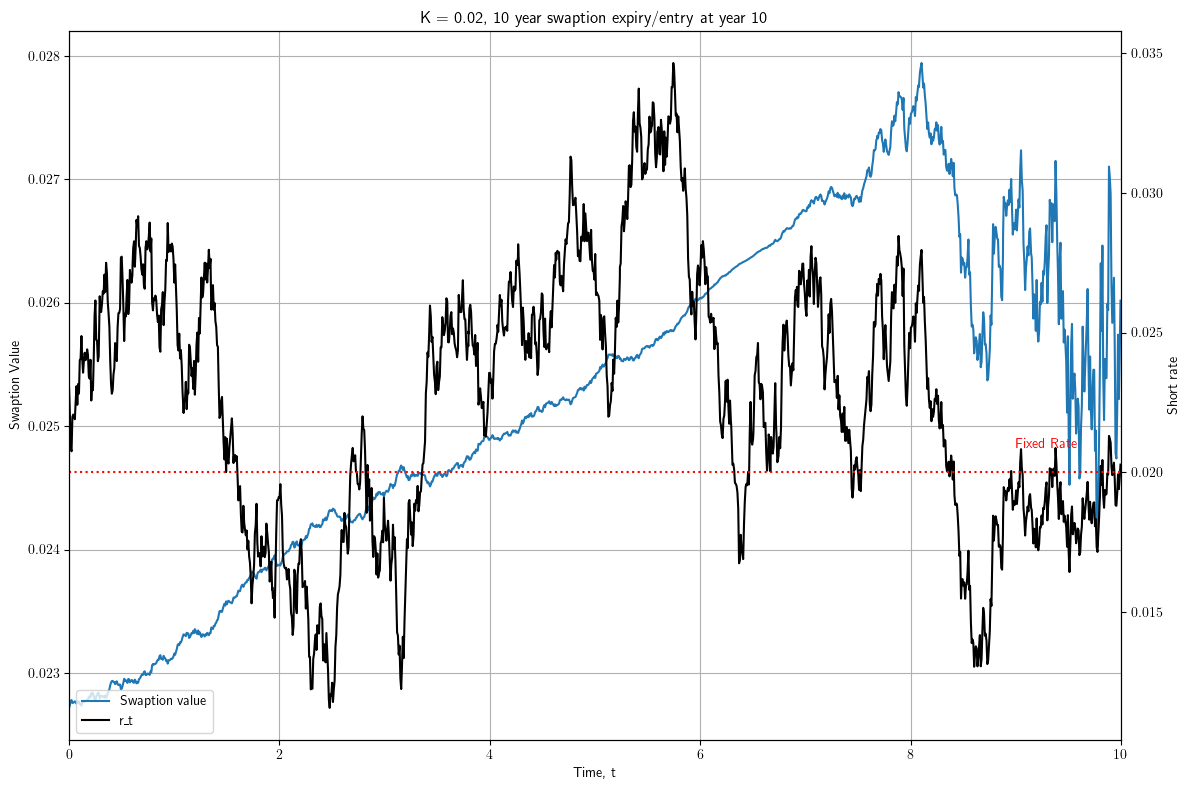

In [93]:
# Looking good
T_s = np.arange(10,21,1)
Fixed = 0.02
swap_prices = np.zeros((len(t_s[t_s <= 10]),1))
swapt_prices = np.zeros((len(t_s[t_s <= 10]),1))

for i in np.arange(0,len(t_s[t_s <= 10])):
    swapt_prices[i] = swaption_price(t_s[i],r[i], T_s, Fixed)
    
print("Swaption value at time %s = 0: %s" %(t_s[0], swapt_prices[0]))

fig1, ax1 = plt.subplots(figsize = (12,8), tight_layout = True)
p1 = ax1.plot(t_s[t_s <= 10],swapt_prices,label = "Swaption value")
ax1.set_title("K = %s, 10 year swaption expiry/entry at year 10" %Fixed)
ax1.set_xlabel("Time, t")
ax1.set_ylabel("Swaption Value")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s[t_s <= 10], r[t_s <= 10], label = r"r_t", color = "black")
h1 = ax2.hlines(Fixed,xmin= 0, xmax=10, label="Strike", linestyles=":",colors="red")
ax2.set_ylabel("Short rate")
ax1.set_xlim((t0,10))
ax1.grid(True)
ax2.text(9, Fixed + 0.001, s= "Fixed Rate", ha = 'left', va = 'center', color = 'red')
ax2.legend(handles=p1+p2, loc = "lower left")
plt.show()


### Monte Carlo
TODO: Improve explanation

$\mathbb{E}[e^{-\int_t^T r_t}X(r_T)| \mathcal{F}_t] \approx \frac{1}{N}\sum_{i=1}^N e^{-\int_t^T \hat{r}_s ds}X(\hat{r}_T)$ so long as $\hat{r}_T$ and $e^{-\int_t^T \hat{r}_s ds}$ are drawn correctly.

### Demonstration/Clarification of how Monte Carlo Loop works using t = 0 as an example, single point pricing with no variance reduction techniques

In [94]:
# Set up the Swap params
K = 0.02
T_s = np.arange(10,21,1)
T = T_s[0]
durations = np.diff(T_s)
payment_dates = T_s[1:]

# Set up pricing known good mean/var functions for r to check against 
mu_hat = lambda T, t, rt: np.e**(-alpha*(T - t))*rt + (theta/alpha)*(1- np.e**(-alpha*(T-t)))
sigma_hat_2 = lambda T, t: (sigma**2/(2*alpha))*(1 - np.e**(-2*alpha*(T-t)))

# Set a high number of samples since we're only running a point
N_samples = 10000

# Find future HullWhite market state distribution
# We as in Ostrovski(1) split r(t) into x(t) + beta(t)
# We treat our current time as t = 0 and the end time as being T, ie s=0 .
t_proxy = T

# The random variable x has a clearly given set of equations for its expectation, and variance and the same for it's integral
x_0 = 0 # by defnition
E_x = 0 # Since x_0 is 0
E_int_x = 0 # Since x_0 is 0
var_x = (sigma**2)/(2*alpha)*(1 - np.e**(-2*alpha*t_proxy))
var_int_x = (sigma**2)/(alpha**2)*(t_proxy + (2/alpha)*np.e**(-alpha*(t_proxy)) - (1/(2*alpha))*np.e**(-2*alpha*t_proxy) - (3/(2*alpha)))
cov_xs = ((sigma**2)/(2*alpha**2)) * (1 - np.e**(-alpha*(t_proxy)))**2

# For beta however they use the market price of ZCBs, much like Grezlek, since we have the analytic equation for ZCBs we can find f exactly
#P(0,t,r0) = np.e**(A(0,t)+B(0,t)*r0)
#->f(0,t) = - d/dt log(P) = - d/dt (A(0,t)+B(0,t)*r0) = -(d/dt A(0,t) + r0*d/dt(B(0,t)))
#d/dt A(0,t)  = -sigma^2/4*alpha^2 * (-2e^(-2alpha * t) + 4e^(-alpha*t) - 2) - (theta/alpha)(1 - e^(-alpha*t))
#d/dt(B(0,t)) = -e^(-alpha*t)
f = -((-sigma**2/alpha**2)*(-2*np.e**(-2*alpha*t_proxy) + 4*np.e**(-alpha*t_proxy) - 2) - (theta/alpha)*(1 - np.e**(-alpha*t_proxy)) - r0*np.e**(-alpha*t_proxy))
eps = 1e-6
f_approx = -(np.log(P(0,t_proxy + eps,r0)) - np.log(P(0,t_proxy,r0)))/(eps)


# And we can check our work with their method for say T_i+1 = T + 0.001, T_i = T
print("--- Diagnostics for f ---")
print("Analytic f: %s" %f)
print("Approx f: %s" %f_approx)
print("So my analytic f is wrong, let's use the approx")

f = f_approx

beta = f + sigma**2/(2*alpha**2)*(1 - np.e**(-alpha*t_proxy))**2
beta_int = -np.log(P(0,t_proxy,r0)) + (sigma**2/(2*alpha**2))*((2/alpha)*np.exp(-alpha*t_proxy) + t_proxy - (1/(2*alpha))*np.exp(-2*alpha*t_proxy) - (3/(2*alpha)))

# Now we have expectations and covariances for the random variables so we can x(t) and add it to beta(t) to generate r(t), and find e^(-\int_0^t r(s)ds) by estimating the integral as beta_int + x_int by the linearity of integration
mkt_samples = rand.multivariate_normal([E_x,E_int_x],[[var_x, cov_xs],[cov_xs,var_int_x]], N_samples, method = "cholesky")
res_r = mkt_samples[:,0] + beta # Samples of r
res_discount = np.exp(-(mkt_samples[:,1] + beta_int)) # Samples of e^(-r)

# We can check that the expectation of r should be mu_hat, with variance sigma_hat_2, and the expecatation of the discount should be the ZCB price
print()
print(r"--- Diagnostics for $r$ and $e^{-\int_0^t r(s) ds}$ ---")
print("Analytic E[r]: %s" %mu_hat(T,0,r0))
print("Approx   E[r]: %s" %np.mean(res_r))
print("Analytic Var(r): %s" %sigma_hat_2(T,0))
print("Approx   Var(r): %s" %np.var(mkt_samples[:,0],ddof=1))
print("Analytic P(t,T): %s" %P(0,T,r0))
print("Approx   P(t,T): %s" %np.mean(res_discount))

# Now we can generate our Swaptions from the fact that V(Swaption_expiry) = V(Swap_expriy)^+
swap_samples = [swap_price(T,x, T_s, K) for x in res_r]
swaption_samples = [x*(x>0) for x in swap_samples]

# And find the relevant expectation as a sum, + bootstrap variance of expectation
discounted_samples = [val*discount for val, discount in zip(swaption_samples, res_discount)]
val = np.mean(discounted_samples)
std_dev = np.sqrt(np.var(discounted_samples, ddof = 1)/N_samples)

print()
print("*--- Resulting Values ---*")
print("Analytic value of swaption at t = 0: %s" %np.squeeze(swapt_prices[0]))
print("Estimated value of swaption at t = 0: %s" %val)
print("Estimated std deviation of estimate: %s" %std_dev)


# Ostrovski (1) Vladimir Ostrovski: EFFICIENT AND EXACT SIMULATION OF THE HULL-WHITE MODEL, published 2013, SSRN ID 2304848, url:https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2304848

--- Diagnostics for f ---
Analytic f: 0.022882455118230074
Approx f: 0.022970613661188466
So my analytic f is wrong, let's use the approx

--- Diagnostics for $r$ and $e^{-\int_0^t r(s) ds}$ ---
Analytic E[r]: 0.023
Approx   E[r]: 0.023033041235664162
Analytic Var(r): 2.9388888828313874e-05
Approx   Var(r): 2.938436471329219e-05
Analytic P(t,T): 0.7947321083246703
Approx   P(t,T): 0.794833797759858

*--- Resulting Values ---*
Analytic value of swaption at t = 0: 0.022717933153111023
Estimated value of swaption at t = 0: 0.022746126945508448
Estimated std deviation of estimate: 4.043520773647837e-05


In [ ]:
### TODO I need to add variance reduction :)
### TODO I need to standardize coloring in plots, the legends give all you need but they're confusing enough as is without me swapping colors between short rate and swaption value halfway through
## TODO Fix the analytic f

### For all time points produced by a run of the interest rate model


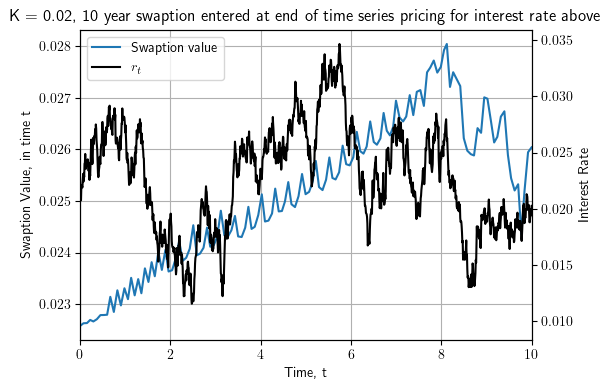

In [95]:
# Set up the Swap params
K = 0.02
T_s = np.arange(10,21,1)
T = T_s[0]
durations = np.diff(T_s)
payment_dates = T_s[1:]

# Set up pricing and mean/var functions for r to check against 
mu_hat = lambda T, t, rt: np.e**(-alpha*(T - t))*rt + (theta/alpha)*(1- np.e**(-alpha*(T-t)))
sigma_hat_2 = lambda T, t: (sigma**2 /2*alpha)*(1 - np.e**(-2*alpha*(T-t)))

# Prep lists for results
end_val = np.zeros((len(t_s),1))
init_val = end_val
local_val = end_val

# Slightly lower sample count, it's noisier but runtime demands it, once I add var reduction techniques it should be fine?
N_samples = 1000

# Run (Parallelized since there's no cross talk, we could parallelize lower level stuff but I think it's more intuitive to do it at as a high a level as possible)
# I also just chose the seemingly simplest way to parallelize from the first thread I  found, but it seems to work? https://stackoverflow.com/questions/9786102/how-do-i-parallelize-a-simple-python-loop
def process(i):
    # Get Time and interest rate
    curr_t = t_s[i]
    curr_r = r[i]

    # Find future HullWhite market state distribution
    # We as in Ostrovski(1) split r(t) into x(t) + beta(t)
    # We treat our current time as t = 0 and the end time as being T.
    t_proxy = T - curr_t

    x_0 = 0 # by defnition
    E_x = 0 # Since x_0 is 0
    E_int_x = 0 # Since x_0 is 0
    var_x = sigma**2/(2*alpha) * (1 - np.e**(-2*alpha*t_proxy))
    var_int_x = (sigma**2)/(alpha**2)*(t_proxy + (2/alpha)*np.e**(-alpha*(t_proxy)) - (1/(2*alpha))*np.e**(-2*alpha*t_proxy) - (3/(2*alpha)))
    cov_xs = ((sigma**2)/(2*alpha**2)) * (1 - np.e**(-alpha*(t_proxy)))**2

    f = -(np.log(P(0,t_proxy + eps,curr_r)) - np.log(P(0,t_proxy,curr_r)))/(eps)
    beta = f + sigma**2/(2*alpha**2)*(1 - np.e**(-alpha*t_proxy))**2
    beta_int = -np.log(P(0,t_proxy,curr_r)) + (sigma**2/(2*alpha**2))*((2/alpha)*np.exp(-alpha*t_proxy) + t_proxy - (1/(2*alpha))*np.exp(-2*alpha*t_proxy) - (3/(2*alpha)))
    mkt_samples = rand.multivariate_normal([E_x,E_int_x],[[var_x, cov_xs],[cov_xs,var_int_x]], N_samples)
    res_r = mkt_samples[:,0] + beta
    res_discount = np.exp(-(mkt_samples[:,1] + beta_int))

    swap_samples = [swap_price(T,x, T_s, K) for x in res_r]
    swaption_samples = [x*(x>0) for x in swap_samples]

    discounted_swaption_samples = [disc*val for disc, val in zip(res_discount,swaption_samples)]
    val = np.mean(discounted_swaption_samples)
    return val

# I set njobs to 4 since I have an old cpu from before thread count was the big thing, you might be able to get better results turning that up or down, it only generates values for 1 in every (step) points, this is to make generation faster
i_val = np.arange(len(r[t_s<10]), step=10)
val = Parallel(n_jobs = 4)(delayed(process)(i) for  i in i_val)
t_val = t_s[i_val]


# Just plotting stuff, the plot looks ugly :/
fig1, ax1 = plt.subplots(figsize = (6,4), tight_layout = True)
p1 = ax1.plot(t_val,val,label = "Swaption value")
ax2 = ax1.twinx()
p2 = ax2.plot(t_s,r,label = r"$r_t$", color = "black")
ax2.set_ylabel("Interest Rate")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %K)
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Swaption Value, in time t")
ax1.set_xlim((t0,T))
ax1.grid(True)
ax1.legend(handles=p1+p2)
plt.show()

# Ostrovski (1) Vladimir Ostrovski: EFFICIENT AND EXACT SIMULATION OF THE HULL-WHITE MODEL, published 2013, SSRN ID 2304848, url:https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2304848

##### A comment on the results above
There is a bias and sometimes a breakpoint visible in the results, these might be possible to reduce through var reduction, but the bias might sitck around depending on cause., and fall as the number of samples rises, at for instance N_samples = 100000 the process behaves perfectly, but this takes 8 minutes even at the reduced timestep.

### Finding Q from gamma
Given that we are using JCIR as presented in Brigos book on CVA we have a closed form solution for the probability of default by T. 
$$\mathbb{Q}(\tau > T) = 1_{\tau > t}\hat{\alpha}(t,T)\mathrm{exp}(-\hat{\beta}(t,T)\lambda_t)$$
$$d \lambda_t = \kappa(\mu_\lambda - \lambda_t) dt + v_\lambda\sqrt{\lambda_t}dZ_t + dJ_t ^{\alpha, \gamma} $$
$$\hat{\alpha}(t,T) = A_{\mathrm{CIR}}(t,T)\left(\frac{2h \mathrm{exp}(\frac{h + \kappa + 2\gamma}{2}(T-t))}{2h + (\kappa + h + 2\gamma)(\mathrm{exp}(h(T-t)) -1)} \right)^{\frac{2\alpha \gamma}{v^2 - 2\kappa \gamma - 2\gamma^2}}$$
$$\hat{\beta}(t,T) = B(t,T) $$
$$A_{\mathrm{CIR}}(t,T) = \left[\frac{2h\mathrm{exp}\{(\kappa+h)(T-t)/2\}}{2h + (\kappa + h)(\mathrm{exp}\left\{(T-t)h\right\} -1)}\right]^{2\kappa\mu/\sigma^2}$$
$$B_{\mathrm{CIR}}(t,T) = \frac{2(\mathrm{exp}\{(T-t)h\}-1)}{2h + (\kappa+h)(\mathrm{exp}\{(T-t)h\}-1)}$$
$$h = \sqrt{\kappa^2 + 2v^2}$$

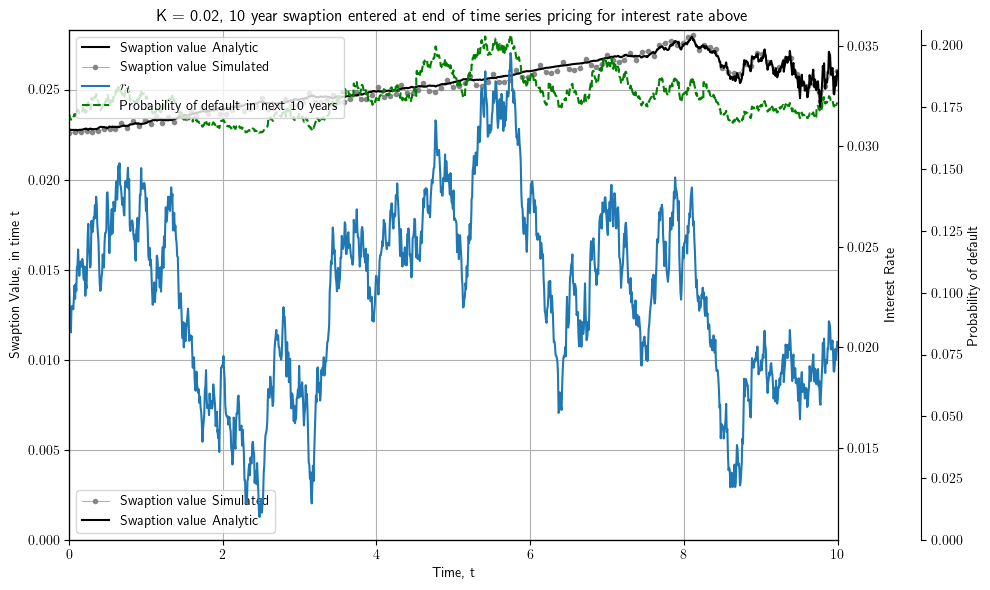

In [97]:
# Defining functions bottom up
h = (kappa**2 + 2*v**2)**(1/2)
B_cir = lambda t,T: (2*(np.exp((T-t)*h)-1))/(2*h + (kappa + h)*(np.exp((T-t)*h)-1))
A_cir = lambda t,T: ((2*h*np.exp((kappa + h)*(T - t)/2))/(2*h + (kappa + h)*(np.exp((T-t)*h) -1)))**(2*kappa*mu/(v**2))
beta_hat = lambda t,T: B_cir(t,T)
alpha_hat = lambda t,T: A_cir(t,T)*((2*h*np.exp((h + kappa + 2*gamma)/(2) * (T-t)))/(2*h + (kappa + h + 2*gamma)*(np.exp(h*(T-t))-1)))**((2*j_alpha*gamma)/(v**2 - 2*kappa*gamma - 2*gamma**2))
Q = lambda t,T,lambd: alpha_hat(t,T)*np.exp(-beta_hat(t,T)*lambd) *(T>t) + (t>=T)

# Find for instance Q(tau > T), ie the probability that we get to t = 10 at least
def_by_10 = np.linspace(0, 0,len(t_s[t_s<10]))
def_by_20 = np.linspace(0, 0,len(t_s[t_s<10]))
def_in_next_10 = np.linspace(0, 0,len(t_s[t_s<10]))
for i in np.arange(0,len(t_s[t_s<10])):
    def_by_10[i] = Q(t_s[i], 10, lambdas[i])
    def_by_20[i] = Q(t_s[i], 20, lambdas[i])
    def_in_next_10[i] = Q(t_s[i], 10 + t_s[i], lambdas[i])

# Make a plot with the interest rate, default probability by T = 10 and the Swaption value all plotted together
# Just plotting stuff, the plot looks ugly :/
fig1, ax1 = plt.subplots(figsize = (10,6), tight_layout = True)
p1 = ax1.plot(t_val,val,label = "Swaption value Simulated", color = "grey", marker = 'o',linewidth = 0.5,markersize = 3, alpha = 0.9)
p1p = ax1.plot(t_s[t_s<10],swapt_prices,label = "Swaption value Analytic", color = "black")
ax2 = ax1.twinx()
ax3 = ax1.twinx()
p3 = None#ax3.plot(t_s, 1-def_by_10, label = r"Probability of default by $T_m = 10$" ,color = "red", linestyle = "--")
p4 = None#ax3.plot(t_s, 1-def_by_20, label = r"Probability of default by $T_n = 20$" ,color = "orange", linestyle = "--")
p5 = ax3.plot(t_s[t_s<10], 1-def_in_next_10, label = "Probability of default in next 10 years" ,color = "green", linestyle = "--")
a3upper = ax3.get_ylim()[1]
ax3.set_ylim((0, a3upper))
p2 = ax2.plot(t_s[t_s<10],r[t_s<10],label = r"$r_t$")
ax3.spines['right'].set_position(('outward', 60))
ax3.set_ylabel("Probability of default")
ax2.set_ylabel("Interest Rate")
ax1.set_title("K = %s, 10 year swaption entered at end of time series pricing for interest rate above" %K)
ax1.set_xlabel("Time, t")
ax1.set_ylabel(r"Swaption Value, in time t")
a1upper = ax1.get_ylim()[1]
ax1.set_ylim((0, a1upper))
ax1.set_xlim((t0,T))
ax1.grid(True)
#ax3.legend(handles=p1p + p1+p2+p3+p4+p5,fancybox = True, framealpha = 0.8, loc = "upper left")
ax3.legend(handles=p1p + p1+p2+p5,fancybox = True, framealpha = 0.8, loc = "upper left")
ax1.legend(loc = "lower left")
plt.show()

#print("Correlation of default probability in next 10 years with swaption value: %s" %(np.corrcoef((1-def_in_next_10[i_val],val))[0][1]))



### Simple Pricing CVA from Q and exposure
We can approximate CVA on a Payer IRS with beginning time $T_a$ and end at $T_b$, with payment times $T_i \in {T_{a+1},...,T_{b}}$ as (See Brigo for proof, Osman Sibai for syntax)
$$\mathrm{CVA}_t =  \sum_{i = a+1}^{b-1} PS(t,T_i,T_b,K,S_{T_i,T_b}(t))(\mathbb{Q}(\{\tau>T_{i-1}\}) - \mathbb{Q}\{\tau >T_i\})$$
in our notation, (since S_{T_i,T_b} is baked in to the function/found from r)
$$\mathrm{CVA}_t =  \sum_{i = a+1}^{b-1} PS(t,T_i,T_b,r_t,K)(\mathbb{Q}(\{\tau>T_{i-1}\}) - \mathbb{Q}\{\tau >T_i\})$$


In [98]:
# CVA deserves a full func, since there is some efficiency to be won, and it's both critical and hard to test
def CVA(t, rt, T_s, K, lambd):
    # Args:
    # t, the current time/the filtration time
    # rt, the current interest rate
    # T_s, the key dates of the swap
    # K, the fixed leg, you pay diff(T_s)*K as a fixed leg
    # lambd, the current probability of default, the rest of the factors needed to find Q come from the model which Q already "knows"
    # Returns: 
    # The CVA estimate, a float

    # First lets rewrite the T_s vector into a T_s vector where all the payments are actually still in the future, and it starts at the last passed adjustment date
    T_s = np.append(T_s,np.inf)
    T_s = [T_s[i] for i in range(len(T_s)-1) if T_s[i+1] > t]

    # Now we find the probability of not defaulting before each payment
    default_after = [Q(t,T_s[k],lambd) for k in range(len(T_s))]

    # Then we find the probability of default before each payment given that we haven't defaulted up to now
    default_buckets = np.diff(default_after)
    
    # Finding hedcing swaptions
    hedging_swaptions = [swaption_price(t,rt, T_s[k:], K) for k in range(len(T_s)-1)]

    return -sum([buc*hedg for buc, hedg in zip(default_buckets,hedging_swaptions)])

In [69]:
i = 59
print("Time is: %s" %t_s[i])
print("CVA: %s" %CVA(t_s[i], r[i],[0,1], 0.01,lambdas[i]))

Time is: 0.4454865181711606
CVA: 0.00010979538299771979


0
0
0.10422001968160868
0
0
0.10433341000004019
0
0
0.10446712228060284
0
0
0.10449703282587736
0
0
0.10439521157790785
0
0
0.1044053647928732
0
0
0.1044275812499757
0
0
0.10445906249795199
0
0
0.10441501501598276
0
0
0.10438058747650548
0
0
0.10446438350435952
0
0
0.10441033810026223
0
0
0.10446249287063696
0
0
0.10436440597791127
0
0
0.10437794661092112
0
0
0.10431780835501073
0
0
0.10441869743660664
0
0
0.10448331335463591
0
0
0.10446093533623557
0
0
0.10445163843681816
0
0
0.10449617844804968
0
0
0.10450201347712094
0
0
0.10449628365882498
0
0
0.1045347426313243
0
0
0.10454840966607297
0
0
0.10462784301189075
0
0
0.1046546691149881
0
0
0.1046076720810585
0
0
0.10476834997843235
0
0
0.10472405688988556
0
0
0.10477010022176599
0
0
0.10467391701904
0
0
0.10454852737553577
0
0
0.10451524736581681
0
0
0.10467033946956399
0
0
0.10469212378576116
0
0
0.10478247649884118
0
0
0.10478512252296777
0
0
0.10464558367897296
0
0
0.10460008811998818
0
0
0.10465752879063306
0
0
0.10468797201915746


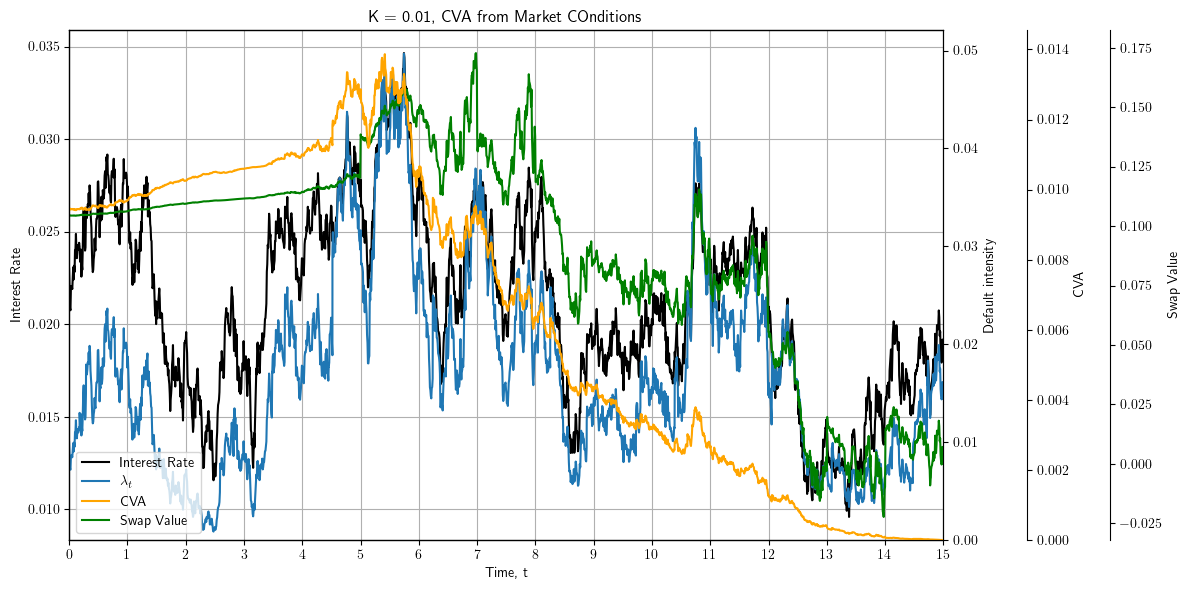

In [ ]:
## Find Delta for CVA (Maybe in Brigo paper)
## Hedge Delta for CVA!
T_s = np.arange(5,16,1)
K = 0.02

def process(i):
    return CVA(t_s[i], r[i], T_s, K, lambdas[i])
i_val = np.arange(len(r), step=1)
CVA_est = Parallel(n_jobs = 4)(delayed(process)(i) for i in i_val)


fig1, ax1 = plt.subplots(figsize = (12,6), tight_layout = True)
p1 = ax1.plot(t_s,r,label = "Interest Rate", color = "black")
ax1.set_ylabel("Interest Rate")
ax1.set_title("K = %s, CVA from Market COnditions" %K)
ax1.set_xlabel("Time, t")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Default intensity")
p2 = ax2.plot(t_s,lambdas,label = r"$\lambda_t$")
currLim = ax2.get_ylim()
ax2.set_ylim((0,currLim[1]))

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 120))
ax3.set_ylabel("Swap Value")
p3 = ax3.plot(t_s,[swap_price(t,rt,T_s,K) for t,rt in zip(t_s,r)], label = "Swap Value", color = 'green')
currLim = ax3.get_ylim()
#x3.set_ylim((-0.25,0.25))

axC = ax1.twinx()
axC.set_ylabel("CVA")
axC.spines['right'].set_position(('outward', 60))
pc = axC.plot(t_s[i_val],CVA_est,label = "CVA", color = "orange")
currLim = axC.get_ylim()
axC.set_ylim((0, currLim[1]))

axC.legend(handles=p1+p2+pc+p3,fancybox = True, framealpha = 0.8, loc = "lower left")
plt.xticks(np.arange(0,16,1))
plt.xlim((0,15))
plt.show()
